In [1]:
import os
import random
import time

import numpy as np
import torch
from absl import app
# from klearn_tcyclone.training_utils.args import FLAGS, ALL_FLAGS
from klearn_tcyclone.training_utils.training_utils import get_default_flag_values
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils import data

from klearn_tcyclone.climada.tc_tracks import TCTracks
from klearn_tcyclone.data_utils import (
    LinearScaler,
)
from klearn_tcyclone.KNF.modules.eval_metrics import RMSE_TCTracks
from klearn_tcyclone.KNF.modules.models import Koopman
from klearn_tcyclone.KNF.modules.train_utils import (
    eval_epoch_koopman,
    train_epoch_koopman,
)
from klearn_tcyclone.knf_data_utils import TCTrackDataset
from klearn_tcyclone.training_utils.training_utils import set_flags
from absl import app, flags

from klearn_tcyclone.training_utils.training_utils import extend_by_default_flag_values

from klearn_tcyclone.koopkernel_seq2seq import KoopmanKernelSeq2Seq, RBFKernel
from klearn_tcyclone.koopkernel_seq2seq import KoopKernelLoss, batch_tensor_context


## Import data

Set some specific parameters and load default values for all other parameters.

In [2]:
flag_params = {
    # "seed": 42,
    "year_range": [1980, 1988],
    # "batch_size": 16,
    "num_epochs": 2,
    "train_output_length": 1,
    "context_length": 14,
}
flag_params["input_length"] = flag_params["context_length"]
flag_params = extend_by_default_flag_values(flag_params)

In [3]:
random.seed(flag_params["seed"])  # python random generator
np.random.seed(flag_params["seed"])  # numpy random generator

torch.manual_seed(flag_params["seed"])
torch.cuda.manual_seed_all(flag_params["seed"])

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

feature_list = [
    "lon",
    "lat",
    "max_sustained_wind",
    # "radius_max_wind",
    # "radius_oci",
    "central_pressure",
    "environmental_pressure",
]

# feature_list = [
#     "lon",
#     "lat",
#     "max_sustained_wind",
#     "radius_max_wind",
#     "radius_oci",
#     "central_pressure",
#     "environmental_pressure",
# ]

# these are not contained as flags
# encoder_hidden_dim = flag_params["hidden_dim"]
# decoder_hidden_dim = flag_params["hidden_dim"]
# encoder_num_layers = flag_params["num_layers"]
# decoder_num_layers = flag_params["num_layers"]

output_dim = flag_params["input_dim"]
num_feats = len(feature_list)
learning_rate = flag_params["learning_rate"]
# ---------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device", device)

scaler = LinearScaler()
eval_metric = RMSE_TCTracks

Device cuda


In [4]:
# Datasets
tc_tracks = TCTracks.from_ibtracs_netcdf(
    provider="official",
    year_range=flag_params["year_range"],
    basin="NA",
)

tc_tracks_train, tc_tracks_test = train_test_split(tc_tracks.data, test_size=0.1)

2025-02-09 20:30:07,167 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file /home/ecjb/climada/data/IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.
2025-02-09 20:31:50,047 - climada.hazard.tc_tracks - WARNING - 49 storm events are discarded because no valid wind/pressure values have been found: 1980199N31284, 1980200N25270, 1980204N23287, 1980226N15339, 1980238N16328, ...


/home/ecjb/packages/climada_python/climada/hazard/tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:


In [5]:
len(tc_tracks_train), tc_tracks_train[5]

(73,
 <xarray.Dataset> Size: 8kB
 Dimensions:                 (time: 134)
 Coordinates:
   * time                    (time) datetime64[ns] 1kB 1986-08-13T12:00:00 ......
     lat                     (time) float32 536B 30.1 30.45 30.8 ... 56.2 56.2
     lon                     (time) float32 536B -84.0 -84.0 -84.0 ... 7.0 8.0
 Data variables:
     radius_max_wind         (time) float32 536B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
     radius_oci              (time) float32 536B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
     max_sustained_wind      (time) float32 536B 10.0 10.0 10.0 ... 15.0 15.0
     central_pressure        (time) float32 536B 1.009e+03 1.01e+03 ... 1.006e+03
     environmental_pressure  (time) float64 1kB 1.01e+03 1.01e+03 ... 1.01e+03
     time_step               (time) float64 1kB 3.0 3.0 3.0 3.0 ... 3.0 3.0 3.0
     basin                   (time) <U2 1kB 'NA' 'NA' 'NA' ... 'NA' 'NA' 'NA'
 Attributes:
     max_sustained_wind_unit:  kn
     central_pressure_unit:    mb
     orig_event

In [6]:
from klearn_tcyclone.data_utils import (
    load_model,
    standardized_context_dataset_from_TCTracks,
)

In [7]:
time_lag = 1
scaler = LinearScaler()
basin = "NA"

The idea is to feed the tensor_context_dataset into the model. Because for the kernels I need the lookback window and the shifted version of this.

In [8]:
tensor_context_train_standardized = standardized_context_dataset_from_TCTracks(
    tc_tracks_train,
    feature_list=feature_list,
    scaler=scaler,
    context_length=flag_params["context_length"],
    time_lag=time_lag,
    fit=True,
    periodic_shift=True,
    basin=basin,
)

In [9]:

train_set = TCTrackDataset(
    input_length=flag_params["input_length"],
    output_length=flag_params["train_output_length"],
    tc_tracks=tc_tracks_train,
    feature_list=feature_list,
    mode="train",
    jumps=flag_params["jumps"],
    scaler=scaler,
    fit=True,
)
valid_set = TCTrackDataset(
    input_length=flag_params["input_length"],
    output_length=flag_params["train_output_length"],
    tc_tracks=tc_tracks_train,
    feature_list=feature_list,
    mode="valid",
    jumps=flag_params["jumps"],
    scaler=scaler,
    fit=False,
)
test_set = TCTrackDataset(
    input_length=flag_params["input_length"],
    output_length=flag_params["test_output_length"],
    tc_tracks=tc_tracks_test,
    feature_list=feature_list,
    mode="test",
    # jumps=flag_params["jumps"], # jumps not used in test mode
    scaler=scaler,
    fit=False,
)
train_loader = data.DataLoader(
    train_set, batch_size=flag_params["batch_size"], shuffle=True, num_workers=1
)
valid_loader = data.DataLoader(
    valid_set, batch_size=flag_params["batch_size"], shuffle=True, num_workers=1
)
test_loader = data.DataLoader(
    test_set, batch_size=flag_params["batch_size"], shuffle=False, num_workers=1
)

if len(train_loader) == 0:
    raise Exception(
        "There are likely too few data points in the test set. Try to increase year_range."
    )

Check why we have nan values!!!

In [10]:
train_loader.dataset[0][0].shape

torch.Size([14, 5])

In [11]:
counter = 0
for inps, tgts in train_loader:
    if counter < 5:
        print(counter)
        print(inps.shape, type(inps))
        print(tgts.shape, type(inps))
        print(inps[0,:,0])
        print(tgts[0,:,0])
        print()
    
    counter += 1


0
torch.Size([32, 14, 5]) <class 'torch.Tensor'>
torch.Size([32, 1, 5]) <class 'torch.Tensor'>
tensor([0.7815, 0.8036, 0.8226, 0.8416, 0.8575, 0.8733, 0.8892, 0.9050, 0.9184,
        0.9319, 0.9422, 0.9525, 0.9588, 0.9652])
tensor([0.9667])

1
torch.Size([32, 14, 5]) <class 'torch.Tensor'>
torch.Size([32, 1, 5]) <class 'torch.Tensor'>
tensor([0.0538, 0.0689, 0.0784, 0.0879, 0.0855, 0.0831, 0.0744, 0.0657, 0.0499,
        0.0340, 0.0293, 0.0245, 0.0238, 0.0230])
tensor([0.0245])

2
torch.Size([32, 14, 5]) <class 'torch.Tensor'>
torch.Size([32, 1, 5]) <class 'torch.Tensor'>
tensor([-0.2043, -0.2162, -0.2257, -0.2352, -0.2494, -0.2637, -0.2755, -0.2874,
        -0.3017, -0.3159, -0.3294, -0.3428, -0.3555, -0.3682])
tensor([-0.3824])

3
torch.Size([32, 14, 5]) <class 'torch.Tensor'>
torch.Size([32, 1, 5]) <class 'torch.Tensor'>
tensor([-0.0428, -0.0546, -0.0665, -0.0784, -0.0895, -0.1006, -0.1108, -0.1211,
        -0.1314, -0.1417, -0.1520, -0.1623, -0.1734, -0.1845])
tensor([-0.1940])

4


In [12]:
tensor_context_inps, tensor_context_tgts = batch_tensor_context(tensor_context_train_standardized, batch_size=flag_params["batch_size"], flag_params=flag_params)
assert torch.all(tensor_context_inps[:,:,1:] == tensor_context_tgts[:,:,:-1])
tensor_context_inps.shape, tensor_context_tgts.shape

(torch.Size([32, 103, 13, 5]), torch.Size([32, 103, 13, 5]))

In [13]:
input_length = tensor_context_train_standardized.context_length-1
input_length

13

In [14]:
rbf = RBFKernel(length_scale=1E-1)
flag_params["koopman_kernel_num_centers"] = 1000

In [15]:
#TODO most parameters don't play a role in model definition -> remove them
koopkernelmodel = KoopmanKernelSeq2Seq(
    kernel=rbf,
    input_dim = num_feats,
    input_length = 13,
    output_length = 1,
    output_dim = 1,
    num_steps = 1,
    num_nys_centers = flag_params["koopman_kernel_num_centers"],
    rng_seed = 42,
    context_mode="last_context"
)

koopkernelmodel._initialize_nystrom_data(tensor_context_train_standardized)

torch.Size([1000, 5]) torch.Size([1000, 5])


In [16]:
def train_one_epoch(model: KoopmanKernelSeq2Seq, optimizer, loss_fun, scheduler, epoch_index, tb_writer, tensor_context_inps, tensor_context_tgts):
    """From https://pytorch.org/tutorials/beginner/introyt/trainingyt.html."""

    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting

    print(range(tensor_context_inps.shape[1]))
    for i in range(tensor_context_inps.shape[1]):

        # Every data instance is an input + label pair
        inputs, labels = tensor_context_inps[:,i], tensor_context_tgts[:,i]
        if model.context_mode == "last_context":
            labels = labels[:, -1, :]

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fun(outputs, labels)
        loss.backward()

        # print(loss.item())

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 10 == 9:
            last_loss = running_loss / 10 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * tensor_context_inps.shape[1] + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    
    print(optimizer.state_dict()["param_groups"][0])

    scheduler.step()

    return last_loss

In [17]:
optimizer = torch.optim.Adam(koopkernelmodel.parameters(), lr=learning_rate)
loss_koopkernel = KoopKernelLoss(koopkernelmodel.nystrom_data_Y, koopkernelmodel._kernel)

from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
tb_writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))

scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=1, gamma=flag_params["decay_rate"]
)  # stepwise learning rate decay




In [18]:
epoch_index = 1
train_loss = []
for epoch_index, epoch in enumerate(range(20)):
    train_loss.append(train_one_epoch(koopkernelmodel, optimizer, loss_koopkernel, scheduler, epoch_index, tb_writer, tensor_context_inps, tensor_context_tgts))


range(0, 103)
  batch 10 loss: 0.2388180747628212
  batch 20 loss: 0.3040406696498394
  batch 30 loss: 0.21430656760931016
  batch 40 loss: 0.18975597843527794
  batch 50 loss: 0.1430390454828739
  batch 60 loss: 0.14588316902518272
  batch 70 loss: 0.12525649592280388
  batch 80 loss: 0.10441838651895523
  batch 90 loss: 0.0865353062748909
  batch 100 loss: 0.07903206497430801
{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'differentiable': False, 'fused': None, 'initial_lr': 0.001, 'params': [0]}
range(0, 103)
  batch 10 loss: 0.08774410709738731
  batch 20 loss: 0.06748025380074978
  batch 30 loss: 0.06270867884159088
  batch 40 loss: 0.08404757753014565
  batch 50 loss: 0.07391072958707809
  batch 60 loss: 0.0618722565472126
  batch 70 loss: 0.062197978422045705
  batch 80 loss: 0.05621521174907684
  batch 90 loss: 0.061757806316018106
  batch 100 loss: 0.06977181807160378
{'lr': 0.000

In [19]:
tensor_context_inps.shape[1]

103

In [20]:
i = 13
inputs, labels = tensor_context_inps[:,i], tensor_context_tgts[:,i]

In [21]:
labels.shape, inputs.shape

(torch.Size([32, 13, 5]), torch.Size([32, 13, 5]))

In [22]:
outs = koopkernelmodel(inputs)

In [23]:
outs

tensor([[ 0.0624, -0.1982,  0.0308,  0.2283, -0.9807],
        [-0.6995, -0.1657, -0.9369,  1.0254, -0.9121],
        [ 0.3630,  0.2852, -0.5414,  0.7856, -1.0500],
        [-0.0590,  0.2890, -0.0866,  0.2665, -0.9577],
        [-0.2439,  0.3004, -0.6501,  0.8730, -1.0102],
        [ 0.0321, -0.0483, -0.3308,  0.5809, -1.0201],
        [ 0.1600,  0.8173, -0.4568,  0.6112, -0.9860],
        [ 0.0111, -0.0944, -0.3363,  0.5920, -1.0276],
        [-0.9784, -0.6480, -0.7237,  0.8128, -0.9419],
        [-0.5495, -0.3140, -0.5114,  0.7514, -1.0106],
        [-0.5373, -0.3550, -0.6262,  0.8298, -0.9677],
        [-0.2073, -0.2946, -0.6102,  0.8675, -1.0914],
        [-0.2077, -0.5895, -0.5773,  0.8521, -1.0009],
        [-0.3586, -0.0392, -0.8241,  0.8079,  0.0036],
        [-0.2377, -0.1928, -0.3935,  0.7069, -1.0653],
        [-0.6517, -0.2877, -0.2341,  0.5385, -0.9702],
        [ 0.1955, -0.5712,  0.0190,  0.2066, -0.9792],
        [-0.0178, -0.6375, -0.3258,  0.7002, -1.0841],
        [-

In [24]:
labels

tensor([[[ 0.1219, -0.4886,  0.0323,  0.2031, -1.0000],
         [ 0.1132, -0.4719,  0.0323,  0.2031, -1.0000],
         [ 0.1069, -0.4532,  0.0323,  0.2031, -1.0000],
         ...,
         [ 0.0689, -0.2640,  0.0323,  0.2031, -1.0000],
         [ 0.0689, -0.2308,  0.0323,  0.2031, -1.0000],
         [ 0.0705, -0.2017,  0.0323,  0.2031, -1.0000]],

        [[-0.5978, -0.1601, -0.6129,  0.8438, -1.0000],
         [-0.6057, -0.1476, -0.4839,  0.8125, -1.0000],
         [-0.6176, -0.1476, -0.5484,  0.8125, -1.0000],
         ...,
         [-0.6793, -0.1642, -0.8387,  0.8906, -1.0000],
         [-0.6833, -0.1642, -0.8710,  0.9062, -1.0000],
         [-0.6888, -0.1642, -0.8710,  0.9062, -1.0000]],

        [[ 0.1370,  0.1081, -0.2581,  0.5234, -1.0000],
         [ 0.1576,  0.1102, -0.2258,  0.5156, -1.0000],
         [ 0.1781,  0.1123, -0.2258,  0.4844, -1.0000],
         ...,
         [ 0.3500,  0.2245, -0.4516,  0.6797, -1.0000],
         [ 0.3729,  0.2599, -0.5484,  0.7188, -1.0000],
  

In [25]:
loss = loss_koopkernel(outs, labels)
loss

/home/ecjb/projects/koopman_learning_tropical_cyclone/klearn_tcyclone/koopkernel_seq2seq.py:294: UserWarning: Using a target size (torch.Size([32, 13, 5])) that is different to the input size (torch.Size([32, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target_transformed, reduction=self.reduction)


RuntimeError: The size of tensor a (32) must match the size of tensor b (13) at non-singleton dimension 1

In [26]:
"""Utils for Koopman model."""
from matplotlib import pyplot as plt
import copy
from matplotlib.axes._axes import Axes

from klearn_tcyclone.KNF.modules.models import Koopman
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def predict_koopman_seq2seq_model(
    time_series: torch.Tensor,
    prediction_steps: int,
    model: KoopmanKernelSeq2Seq,
):
    assert len(time_series.shape) == 2
    # tgts_dummy only needed to set the number of predicted time steps by model.
    """
    Note: The model performs a number of single_forward steps, each predicting
    `num_steps` future time steps, such that the total number of predicted time steps is
    larger than `tgts.shape[1]`, i.e. `prediction_steps` or the `output_length` of the
    dataset. In the end only the first `output_length` predicted data points are given
    as output, the remaining (further) steps are discarded.
    """
    if model.context_mode == "no_context":
        time_series_unsqueeze = time_series.unsqueeze(0).to(device)
    elif model.context_mode == "full_context":
        time_series_unsqueeze = time_series[-model.input_length:].unsqueeze(0).to(device)
    if model.context_mode == "last_context":
        time_series_unsqueeze = time_series[-model.input_length:].unsqueeze(0).to(device)
    # outs_list = []
    prediction = time_series_unsqueeze
    # outs_list.append(prediction)
    for _ in range(prediction_steps):
        new_prediction = model(prediction)
        new_prediction = new_prediction.unsqueeze(1).to(device)
        if model.context_mode == "last_context":
            prediction = torch.cat([prediction[:,1:], new_prediction], dim=1)
        else:
            prediction = torch.cat([prediction[:,1:], new_prediction[:,-1:]], dim=1)
        # outs_list.append(prediction)

    res = prediction[0,-prediction_steps:]
    return res


from klearn_tcyclone.plot_utils import plot_TCTrackDataset_item_2D

def plot_TCTrackDataset_item_2D_with_prediction_koopman_seq2seq(
    tc_tracks_dataset: TCTrackDataset,
    idx: int,
    prediction_steps,
    model,
    ax: Axes,
    color: str,
    dimensions: tuple[int, int] = (0, 1),
):
    plot_TCTrackDataset_item_2D(tc_tracks_dataset, idx, ax, color, dimensions)
    time_series, _ = tc_tracks_dataset[idx]
    predictions = predict_koopman_seq2seq_model(
        time_series, prediction_steps, model
    )
    predictions = predictions.cpu().data.numpy()
    ax.plot(
        predictions[:, dimensions[0]],
        predictions[:, dimensions[1]],
        marker="s",
        color=color,
    )


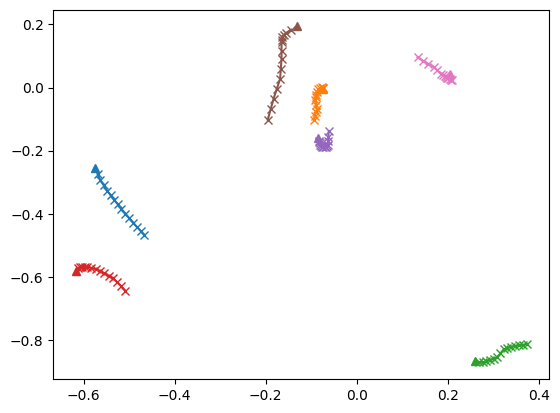

In [27]:
fig, ax = plt.subplots()
for i, idx in enumerate(np.random.randint(0, len(train_set), 7)):
    plot_TCTrackDataset_item_2D(train_set, idx, ax, color=f"C{i}")

In [28]:
# i = 13
# inputs, labels = tensor_context_inps[:,i], tensor_context_tgts[:,i]

In [29]:
idx = 1
time_series, _ = train_set[idx]
time_series_unsqueeze = time_series[-koopkernelmodel.input_length:].unsqueeze(0).to(device)
outs = time_series_unsqueeze

In [30]:
prediction_steps = 3
res_list = predict_koopman_seq2seq_model(time_series, prediction_steps=prediction_steps, model=koopkernelmodel)

In [31]:
time_series, res_list

(tensor([[ 0.0301,  0.1289, -0.2903,  0.6328, -1.0000],
         [ 0.0388,  0.1351, -0.2903,  0.6406, -1.0000],
         [ 0.0499,  0.1414, -0.2903,  0.6562, -1.0000],
         [ 0.0610,  0.1476, -0.2903,  0.6719, -1.0000],
         [ 0.0721,  0.1601, -0.2903,  0.6797, -1.0000],
         [ 0.0831,  0.1726, -0.2903,  0.6875, -1.0000],
         [ 0.0966,  0.1809, -0.2903,  0.6953, -1.0000],
         [ 0.1101,  0.1892, -0.2903,  0.7031, -1.0000],
         [ 0.1211,  0.1975, -0.3548,  0.7109, -1.0000],
         [ 0.1322,  0.2058, -0.4194,  0.7188, -1.0000],
         [ 0.1449,  0.2141, -0.4839,  0.7500, -1.0000],
         [ 0.1576,  0.2225, -0.5484,  0.7812, -1.0000],
         [ 0.1750,  0.2266, -0.6129,  0.8047, -1.0000],
         [ 0.1924,  0.2308, -0.6774,  0.8281, -1.0000]]),
 tensor([[ 0.1467,  0.1916, -0.6607,  0.8610, -1.0334],
         [ 0.1583,  0.1962, -0.7138,  0.9103, -1.0567],
         [ 0.1652,  0.1963, -0.7342,  0.9257, -1.0562]], device='cuda:0',
        grad_fn=<SliceBackwa

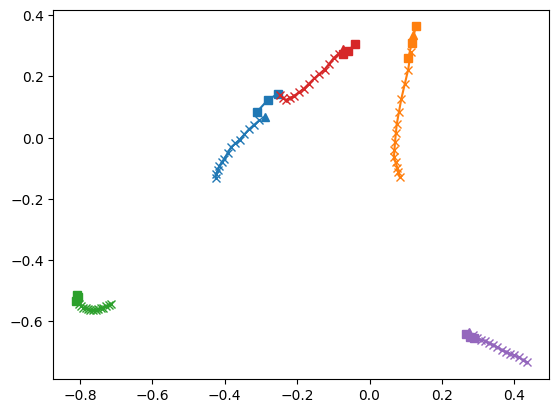

In [36]:
prediction_steps = 3

fig, ax = plt.subplots()
for i, idx in enumerate(np.random.randint(0, len(train_set), 5)):

    plot_TCTrackDataset_item_2D_with_prediction_koopman_seq2seq(
        train_set,
        idx,
        prediction_steps=prediction_steps,
        model=koopkernelmodel,
        ax=ax,
        color=f"C{i}"
    )

# ax.set_xlim(-1, 1)
# ax.set_ylim(-1, 1)
# ax.set_xlim(-6,-5)
# ax.set_ylim(-9.25,-9)